In [1]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

## Simple Test Problem

In [2]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

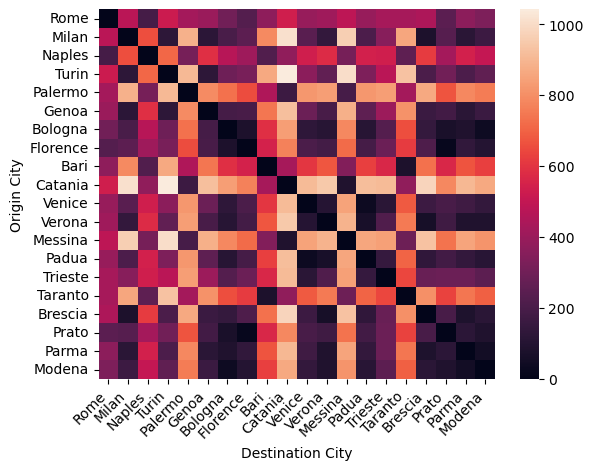

In [3]:
fig, ax = plt.subplots()
sns.heatmap(test_problem, xticklabels=CITIES, yticklabels=CITIES, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("Destination City")
ax.set_ylabel("Origin City")
plt.show()

In [ ]:
def fitness(chromosome, problem):
    """Calculate the fitness (total distance) of a chromosome."""
    destinations = np.roll(chromosome, -1)
    total_distance = problem[chromosome, destinations].sum()
    return total_distance


def chromosome_to_adjlist(chromosome):
    """Convert a chromosome to its adjacency list representation."""
    adjlist = [set() for _ in range(len(chromosome))]
    for i in range(len(chromosome)):
        src = chromosome[i]
        dest = chromosome[(i + 1) % len(chromosome)]
        adjlist[src].add(dest.item())
        adjlist[dest].add(src.item())
    return adjlist


class Individual:
    """Class representing an individual in the population."""
    def __init__(self, chromosome, problem):
        self.chromosome = chromosome
        self.fitness = fitness(chromosome, problem)
        self.adjlist = chromosome_to_adjlist(chromosome)
        self.problem = problem

    def join_adjlist(self, other):
        """Join adjacency lists of self and other individual."""
        new_adjlist = [self.adjlist[i].union(
            other.adjlist[i]) for i in range(len(self.chromosome))]
        return new_adjlist
    
    def swap_mutation(self):
        """Perform swap mutation on the chromosome."""
        idx1, idx2 = np.random.choice(len(self.chromosome), size=2, replace=False)
        self.chromosome[idx1], self.chromosome[idx2] = self.chromosome[idx2], self.chromosome[idx1]
        self.fitness = fitness(self.chromosome, self.problem)
        self.adjlist = chromosome_to_adjlist(self.chromosome)
    
    def inversion_mutation(self):
        """Perform inversion mutation on the chromosome."""
        start_idx, end_idx = np.random.choice(len(self.chromosome), size=2, replace=False)
        if start_idx > end_idx:
            start_idx, end_idx = end_idx, start_idx
        self.chromosome[start_idx:end_idx+1] = self.chromosome[start_idx:end_idx+1][::-1]
        self.fitness = fitness(self.chromosome, self.problem)
        self.adjlist = chromosome_to_adjlist(self.chromosome)

In [ ]:
def edge_recombination(parent1, parent2):
    new_adjlist = parent1.join_adjlist(parent2)
    starting_parent = np.random.choice([parent1, parent2])
    current_node = starting_parent.chromosome[0].item()
    unvisited = set(range(len(parent1.chromosome)))
    child_chromosome = []
    while unvisited:
        # Select the next city
        child_chromosome.append(current_node)
        unvisited.remove(current_node)
        # Update adjacency list
        for neighbors in new_adjlist:
            neighbors.discard(current_node)
        # Choose next node
        if new_adjlist[current_node]:
            next_node = min(new_adjlist[current_node],
                            key=lambda n: len(new_adjlist[n]))
        else:
            next_node = np.random.choice(
                list(unvisited)) if unvisited else None
        current_node = next_node
    offspring = Individual(np.array(child_chromosome), parent1.problem)
    return offspring

def inver_over_recombination(parent1, parent2, p=0.1):
    offspring_chromosome = parent1.chromosome.copy()
    c = np.random.choice(offspring_chromosome)
    remaining = set(offspring_chromosome)
    remaining.remove(c)

    while remaining:
        # Choose c'
        if np.random.random() < p:
            c_prime = np.random.choice(list(remaining))
        else:
            c_idx_p2 = np.where(parent2.chromosome == c)[0][0]
            c_prime = parent2.chromosome[(c_idx_p2 + 1) % len(parent2.chromosome)]

        # Update c index in offspring
        c_idx_p1 = np.where(offspring_chromosome == c)[0][0]
        c_prev = offspring_chromosome[(c_idx_p1 - 1) % len(offspring_chromosome)]
        c_next = offspring_chromosome[(c_idx_p1 + 1) % len(offspring_chromosome)]

        # Stop if c' is adjacent to c
        if c_prime == c_prev or c_prime == c_next:
            break

        # Get c' index and invert segment
        c_prime_idx_p1 = np.where(offspring_chromosome == c_prime)[0][0]
        if c_idx_p1 < c_prime_idx_p1:
            offspring_chromosome[c_idx_p1:c_prime_idx_p1 + 1] = \
                offspring_chromosome[c_idx_p1:c_prime_idx_p1 + 1][::-1]
        else:
            segment = np.concatenate((offspring_chromosome[c_idx_p1:], offspring_chromosome[:c_prime_idx_p1 + 1]))
            segment = segment[::-1]
            offspring_chromosome[c_idx_p1:] = segment[:len(offspring_chromosome) - c_idx_p1]
            offspring_chromosome[:c_prime_idx_p1 + 1] = segment[len(offspring_chromosome) - c_idx_p1:]

        # Prepare for next iteration
        remaining.discard(c_prime)
        c = c_prime

    offspring = Individual(offspring_chromosome, parent1.problem)
    return offspring

In [ ]:
def greedy_initialization(problem, neighborhood_size=5):
    """Generate a solution using a greedy randomized approach."""
    problem_size = problem.shape[0] 
    # Start from a random city
    current_city = np.random.randint(problem_size)
    solution = [current_city]
    unvisited = set(range(problem_size))
    unvisited.remove(current_city)
    # Build solution
    while unvisited:
        # Find nearest neighbors
        tmp = np.array(list(unvisited))
        tmp_distances = problem[current_city, tmp]
        nearest_indices = np.argsort(tmp_distances)[:neighborhood_size]
        neighborhood = tmp[nearest_indices]
        # Randomly select the next city from the neighborhood
        next_city = np.random.choice(neighborhood)
        solution.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city
    return np.array(solution)

In [ ]:
class GASolver:
    def __init__(self, problem, population_size, initialization_neighborhood_size, generations, generation_size, edge_recombination_p=0.7, mutation_rate=0.2):
        self.problem = problem
        self.population_size = population_size
        self.initialization_neighborhood_size = initialization_neighborhood_size
        self.generations = generations
        self.generation_size = generation_size
        self.edge_recombination_p = edge_recombination_p
        self.mutation_rate = mutation_rate
        # Initialize population with greedy initialization
        def get_individual(): return greedy_initialization(
            problem, self.initialization_neighborhood_size)
        self.population = [Individual(get_individual(), problem)
                           for _ in range(population_size)]
        self.best_individual = min(
            self.population, key=lambda ind: ind.fitness)

    def evolve(self):
        for _ in tqdm(range(self.generations)):
            new_offsprings = []
            for _ in range(self.generation_size):
                # Select parents
                parent1, parent2 = np.random.choice(
                    self.population, size=2, replace=False)
                if np.random.random() < self.edge_recombination_p:
                    # Apply edge recombination
                    offspring = edge_recombination(parent1, parent2)
                    # Apply mutation
                    if np.random.random() < self.mutation_rate:
                        offspring.inversion_mutation()
                else:
                    # Apply inver-over recombination
                    offspring = inver_over_recombination(parent1, parent2)
                    # Inver-over is mutation-heavy, so we skip additional mutation here
                new_offsprings.append(offspring)
            # Create new population
            self.population.extend(new_offsprings)
            self.population.sort(key=lambda ind: ind.fitness)
            self.population = self.population[:self.population_size]
            self.best_individual = self.population[0]
        return self.best_individual

In [8]:
test_solver = GASolver(
    problem=test_problem,
    population_size=100,
    initialization_neighborhood_size=5,
    generations=1000,
    generation_size=20,
    edge_recombination_p=0.7,
    mutation_rate=0.2,
)
test_solver.evolve()
test_solver.best_individual.fitness

100%|██████████| 1000/1000 [00:03<00:00, 261.26it/s]


np.float64(2823.7899999999995)

In [9]:
np.array(CITIES)[test_solver.best_individual.chromosome]

array(['Florence', 'Prato', 'Bologna', 'Modena', 'Parma', 'Genoa',
       'Turin', 'Milan', 'Brescia', 'Verona', 'Padua', 'Venice',
       'Trieste', 'Bari', 'Taranto', 'Messina', 'Catania', 'Palermo',
       'Naples', 'Rome'], dtype='<U8')

## Common tests

In [10]:
problem_paths = os.listdir("lab2")
problem_paths.remove("test_problem.npy")

In [11]:
problem = np.load(os.path.join("lab2", "problem_r2_10.npy"))

In [12]:
results_dict = {}
for problem_path in problem_paths:
    problem = np.load(os.path.join('lab2', problem_path))
    # Adjust edge recombination probability based on problem type r
    # since the distance matrix is asymmetric
    # Inver-over when may not work in this case
    if "_r" in problem_path:
        edge_recombination_p = 1
    else:
        edge_recombination_p = 0.7
    problem_solver = GASolver(
        problem=problem,
        population_size=100,
        initialization_neighborhood_size=1,
        generations=1000,
        generation_size=10,
        edge_recombination_p=edge_recombination_p,
        mutation_rate=0.2,
    )
    problem_solver.evolve()
    results_dict[problem_path] = problem_solver.best_individual.fitness

100%|██████████| 1000/1000 [01:55<00:00,  8.63it/s]


In [13]:
for problem_path, best_fitness in results_dict.items():
    print(f"{problem_path}: {best_fitness}")

problem_g_10.npy: 1497.6636482252907
problem_g_100.npy: 4243.9132401854085
problem_g_1000.npy: 14072.260307289629
problem_g_20.npy: 1755.5146770830047
problem_g_200.npy: 6203.973525529696
problem_g_50.npy: 2815.0458787078187
problem_g_500.npy: 9577.42126146522
problem_r1_10.npy: 193.14467988756027
problem_r1_100.npy: 762.1211140896535
problem_r1_1000.npy: 2591.2304126523113
problem_r1_20.npy: 350.38085739382245
problem_r1_200.npy: 1134.810104096949
problem_r1_50.npy: 574.1106119828945
problem_r1_500.npy: 1761.84445767003
problem_r2_10.npy: -411.70171555249846
problem_r2_100.npy: -4667.6785939191805
problem_r2_1000.npy: -49477.87190538827
problem_r2_20.npy: -807.9116696351792
problem_r2_200.npy: -9582.832620172623
problem_r2_50.npy: -2232.376576129727
problem_r2_500.npy: -24584.048345320494


In [14]:
# Negative values?
np.any(problem < 0)

np.True_

In [15]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

False

In [16]:
# Symmetric matrix?
np.allclose(problem, problem.T)

False

In [17]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

False